In [11]:
# /!\ Before running the lab make sure every additional libraries is installed 

# Import local libraries
from visualization import *
from utils import *


# Task n°1


The functions you need to modify are located in:
-  box_to_corner -> visualization.py

-  get_boxes_in_actor_frame -> utils.py

In [12]:
n_frame = 0
actor = 'ego_vehicle'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
print(irsu_boxes.shape)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]


show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

(10, 8)


## Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are:
-  box_to_corner (already done in task 1) -> visualization.py
-  get_available_point_clouds, get_available_boxes_in_ego_frame, get_boxes_in_actor_frame(already done in task 1) -> utils.py

In [13]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]#

merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

# Task n°3

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  box_to_pixels, points_to_pixels-> visualization.py
-  filter_points -> utils.py

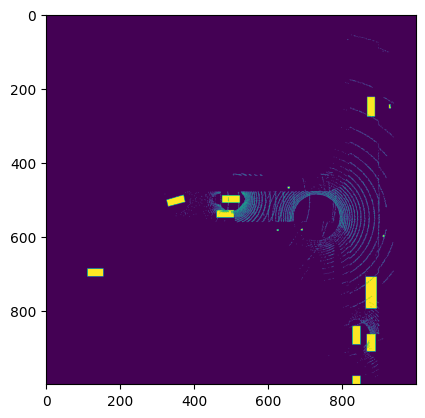

In [14]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

# ------------------ Get Waypoints that belongs to the ground floor ------------------
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle

filtered_points = filter_points(merged_points, points_range)
show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

# ------------------  Project bbox of actors on the image  -----------------
for i in range(irsu_boxes.shape[0]): 
    box_mask = box_to_pixels(irsu_boxes[i:i+1, :7], bev_imsize, bev_resolution)
    bev_occupancy[box_mask > 0] = 255

# ------------------  Project navigable space on the image ------------------  
navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

for pixel in navigable_space:
    bev_occupancy[pixel[1], pixel[0]] = 150


plt.imshow(bev_occupancy)

## Task 4


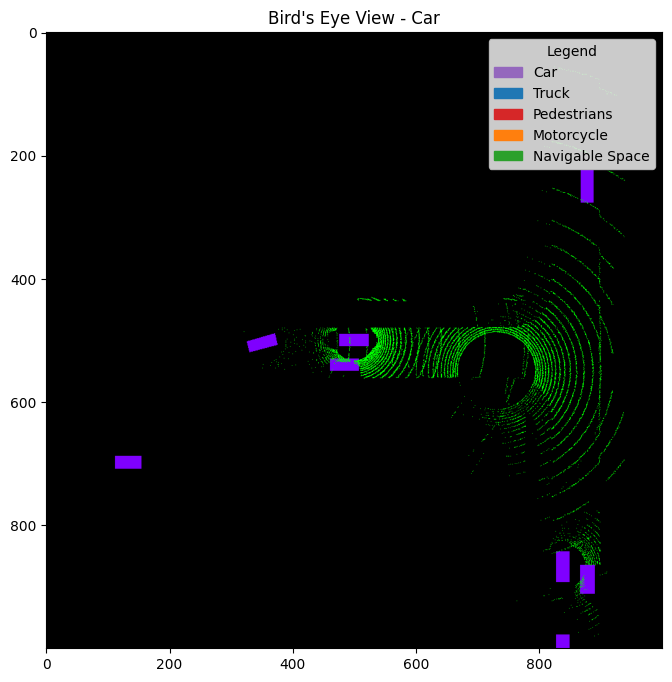

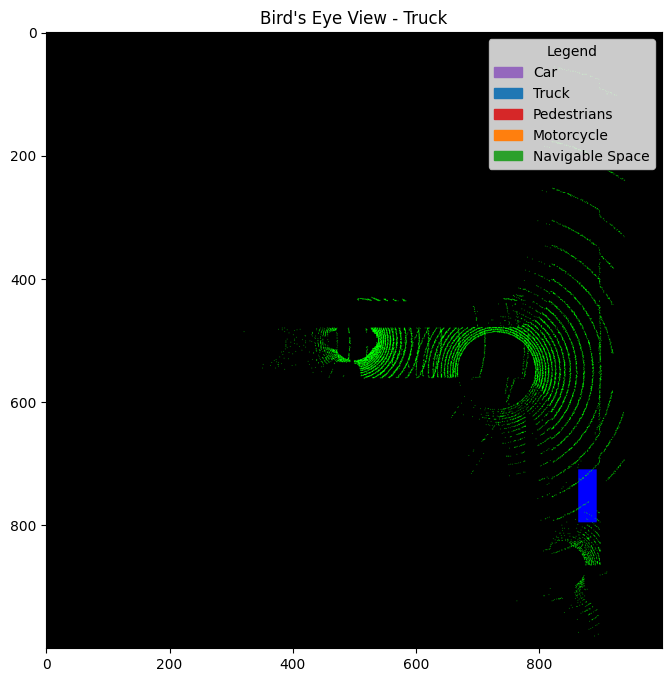

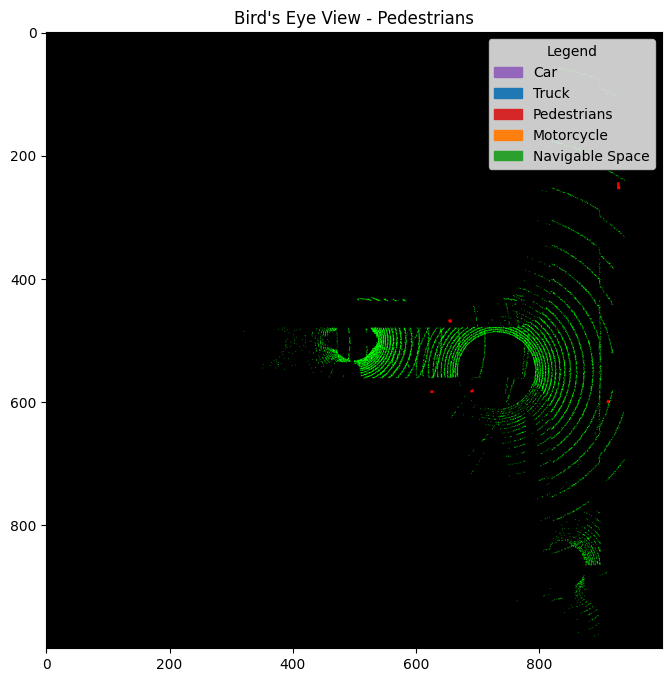

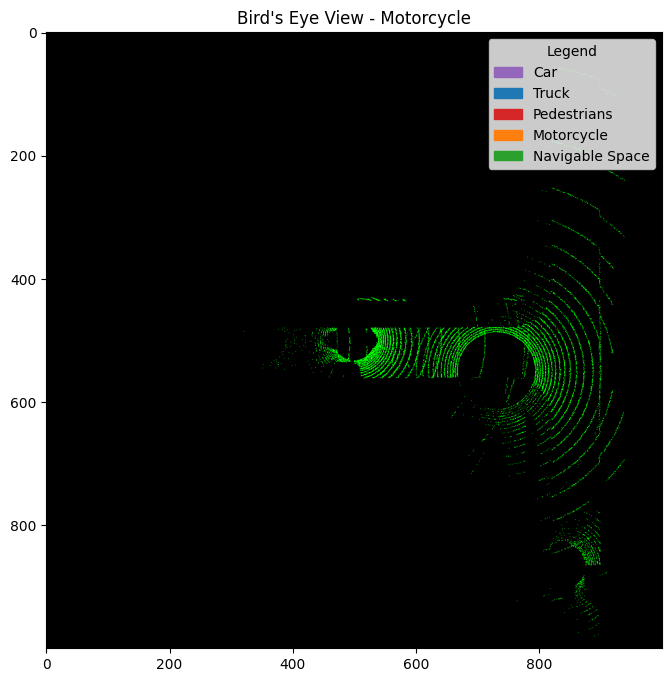

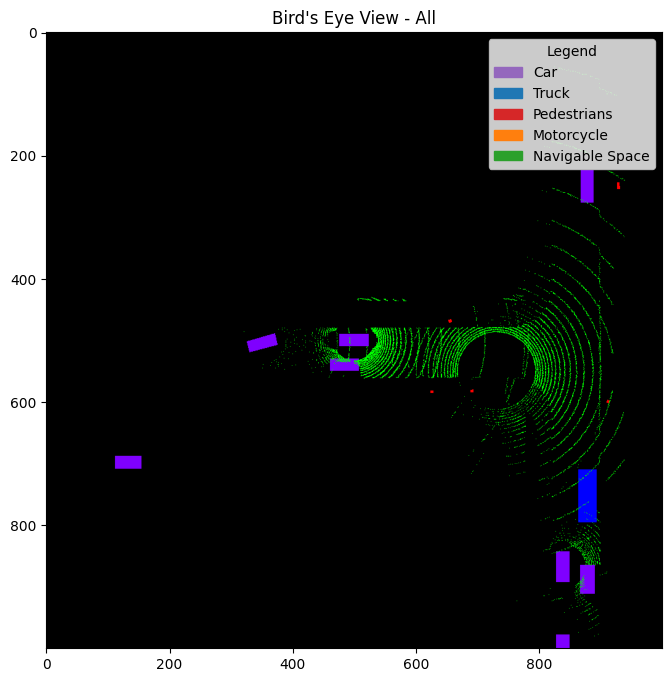

In [15]:
# Each detection is attached with one class label, use it to filter out the detections of interest (e.g. vehicles, pedestrians, etc.)
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For custom legend patches

# Updated CLASS_COLORS for box identification
CLASS_COLORS = np.array([
    [0.5, 0.0, 1.0],  # Blue for Truck
    [0.0, 0.0, 1.0],  # Purple for Car
    [1.0, 0.65, 0.0],  # Red for Pedestrians
    [1.0, 0.0, 0.0],  # Orange for Motorcycle
    [0.0, 1.0, 0.0]   # Green for All
])

# Function to handle button clicks
def update_method(button):
    method = button.description
    boxes = detection_obj(n_frame, actors, method)
    box_colors = CLASS_COLORS[boxes[:, -1].astype(np.int32)]

    # Filter points within the range
    points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # Range for ground floor
    filtered_points = filter_points(merged_points, points_range)

    # Visualize filtered points and bounding boxes
    show_objects(filtered_points, boxes[:, :7], box_colors)

    # Create BEV image
    bev_resolution = 0.1  # meters per pixel
    bev_imsize = np.ceil((points_range[3:5] - points_range[:2]) / bev_resolution).astype(int)
    bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0], 3), dtype=np.uint8)  # Use RGB for better visualization

    # Overlay bounding boxes on BEV
    for i in range(boxes.shape[0]):
        box_mask = box_to_pixels(boxes[i:i+1, :7], bev_imsize, bev_resolution)
        bev_occupancy[box_mask > 0] = box_colors[i] * 255  # Scale colors from 0-1 to 0-255

    # Overlay navigable space
    navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)
    for pixel in navigable_space:
        bev_occupancy[int(pixel[1]), int(pixel[0])] = [0, 255, 0]  # Green for navigable space

    # Show BEV image
    plt.figure(figsize=(10, 8))  # Increase figure size for clarity
    plt.imshow(bev_occupancy, origin='lower')
    plt.title(f"Bird's Eye View - {method}")
    plt.axis('on')  # Show axes for clarity
    plt.gca().invert_yaxis()  # Flip the plot around the x-axis

    # Add legend for the BEV image
    legend_patches = [
        mpatches.Patch(color='#9467bd', label='Car'),
        mpatches.Patch(color='#1f77b4', label='Truck'),
        mpatches.Patch(color='#d62728', label='Pedestrians'),
        mpatches.Patch(color='#ff7f0e', label='Motorcycle'),
        mpatches.Patch(color='#2ca02c', label='Navigable Space'),
    ]
    plt.legend(handles=legend_patches, loc='upper right', title="Legend", fontsize=10)

    plt.show()

# Button configurations
buttons = {
    'Car': '#9467bd',           # Purple
    'Truck': '#1f77b4',         # Blue
    'Pedestrians': '#d62728',   # Red
    'Motorcycle': '#ff7f0e',    # Orange
    'All': '#2ca02c'            # Green
}

# Create and display buttons
button_widgets = [
    widgets.Button(description=name, style={'button_color': color}, layout=widgets.Layout(width='100px', height='40px'))
    for name, color in buttons.items()
]

for button in button_widgets:
    button.on_click(update_method)

display(widgets.HBox(button_widgets))